In [1]:
import numpy as np

from os import listdir
from os.path import isfile, join
import networkx as nx

import dgl
from dgl.nn import RelGraphConv

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np


from dgl.nn import GraphConv, AvgPooling
from dgl.nn.pytorch import Sequential

from dgl.dataloading import GraphDataLoader
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold, StratifiedKFold

import matplotlib.pyplot as plt

from torch.optim import lr_scheduler

import pickle

from copy import deepcopy
from datetime import datetime
from utils import parse_date_from_string

In [2]:
pickle_name = 'nx_url_dataset.pickle'
with open(pickle_name, 'rb') as f:
    train_set, test_set = pickle.load(f)

In [3]:
d = '2013-07-28 00:00:00'
datetime.strptime(d, "%Y-%m-%d %H:%M:%S")

datetime.datetime(2013, 7, 28, 0, 0)

In [4]:
# g = train_set[0][0]
# print(g.nodes(data=True)[0]['publication_date'])
# datetime.strptime(g.nodes(data=True)[0]['publication_date'], "%Y-%m-%dT%H:%M:%S")
# len("2019-09-01T00:00:00"

20178.55252269499


(array([6.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+01, 5.7000e+01, 2.3200e+02, 8.5000e+02, 1.5034e+04]),
 array([    0. ,  2086.8,  4173.6,  6260.4,  8347.2, 10434. , 12520.8,
        14607.6, 16694.4, 18781.2, 20868. ]),
 <BarContainer object of 10 artists>)

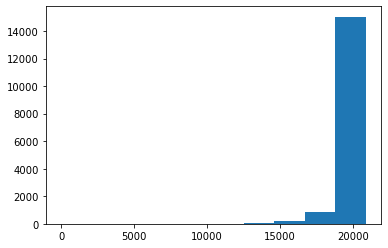

In [5]:
def parse_date(text):
    d = None
    try:
        d = datetime.strptime(text[:19], "%Y-%m-%dT%H:%M:%S")
    except Exception:
        pass
    try:
        if d is None:
            d = datetime.strptime(text[:19], "%Y-%m-%d %H:%M:%S")
    except Exception:
        pass
    return d

x = []
for j in range(len(train_set)):

    g = train_set[j][0]
    base_date = g.nodes[0]['publication_date']
#     print('\n\n\n',base_date)
    node_domains = dict()
    for i in range(len(g.nodes)):
        if g.nodes[i]['publication_date'] is None:
#                 print(None)
            x.append(None)
        str_date = g.nodes[i]['publication_date']
        x.append(parse_date(str_date))
existing_dates = [a for a in x if a is not None]
a = 0
base_date = min(existing_dates)
times = np.asarray([(x-base_date).days for x in existing_dates ])
# existing_dates[0] + existing_dates[1]
# print(*existing_dates, sep='\n')
# sum(existing_dates)
print(times.mean())
# print(base_date + int(times.mean()))
plt.hist(times)

In [6]:
e2id = {'title':0, 'link':0, 'domain':0}

def add_encoding(dataset):
    for j in range(len(dataset)):
        g = dataset[j][0]
        base_date = g.nodes[0]['publication_date']
        g.nodes[0]["time_diff"] = 0
        g.nodes[0]["no_time"] = 0 
        node_domains = dict()
        for e in g.edges:
            date_e0 = parse_date(g.nodes[e[0]]['publication_date'])
            date_e1 = parse_date(g.nodes[e[1]]['publication_date'])
            if date_e0 is not None and date_e1 is not None:
                g.nodes[e[0]]["time_diff"] = (date_e0-date_e1).days
                g.nodes[e[0]]["no_time"] = 0 
            else:
                g.nodes[e[0]]["time_diff"] = 0
                g.nodes[e[0]]["no_time"] = 1
        for e in g.edges:
            if g.edges[e[0], e[1]]['link_type'] == 'title':
                g.edges[e[0], e[1]]['type'] = e2id['title']
                
            else:
                g.edges[e[0], e[1]]['type'] = e2id['link']
                
        node_domains = dict()
        for i in range(len(g.nodes)):
            g.nodes[i]['h'] = torch.tensor([0., 0., 0., g.nodes[i]['time_diff'], g.nodes[i]['no_time']])
            g.nodes[i]['h'][g.nodes[i]['level']] = 1.
            if g.nodes[i]['domain'] not in node_domains:
                node_domains[g.nodes[i]['domain']] = [i]
            else:
                node_domains[g.nodes[i]['domain']].append(i)
            
#         print(node_domains)
#         for domain in node_domains:
#             if len(node_domains[domain]) >1:
#                 for d1 in node_domains[domain]:
#                     for d2 in node_domains[domain]:
#                         if d1 == d2:
#                             continue
#                         g.add_edge(d1, d2)
#                         g.edges[d1, d2]['type'] = e2id['domain']
            
                
#             else:
#                 g.edges[e[0], e[1]]['type'] = e2id['link']
#             print(str_date, parse_date(str_date))
#             print(g.nodes[i]['publication_date'], parse_date_from_string(g.nodes[i]['publication_date']))
    
                        
    return dataset
# add_encoding(train_set)
# 0/0
train_set = add_encoding(train_set)
test_set = add_encoding(test_set)

In [7]:
for g, _ in train_set:
    print(g.nodes(data=True))

[(0, {'publication_date': '2019-09-01T00:00:00', 'level': 0, 'domain': 'euronews.com', 'time_diff': 0, 'no_time': 0, 'h': tensor([1., 0., 0., 0., 0.])}), (1, {'publication_date': '2019-09-01T00:00:00', 'level': 1, 'domain': 'dw.com', 'time_diff': 0, 'no_time': 0, 'h': tensor([0., 1., 0., 0., 0.])}), (2, {'publication_date': '2019-09-04T00:00:00', 'level': 1, 'domain': 'nytimes.com', 'time_diff': 3, 'no_time': 0, 'h': tensor([0., 1., 0., 3., 0.])}), (3, {'publication_date': '2019-09-01T00:00:00', 'level': 1, 'domain': 'businessinsider.com', 'time_diff': 0, 'no_time': 0, 'h': tensor([0., 1., 0., 0., 0.])}), (4, {'publication_date': '2019-09-02T00:00:00', 'level': 1, 'domain': 'theguardian.com', 'time_diff': 1, 'no_time': 0, 'h': tensor([0., 1., 0., 1., 0.])}), (5, {'publication_date': '2019-09-01T00:00:00', 'level': 1, 'domain': 'dailymail.co.uk', 'time_diff': 0, 'no_time': 0, 'h': tensor([0., 1., 0., 0., 0.])}), (6, {'publication_date': '2019-09-01T00:00:00', 'level': 1, 'domain': 'sltr

[(0, {'publication_date': '2022-01-08T00:00:00', 'level': 0, 'domain': 'economist.com', 'time_diff': 0, 'no_time': 0, 'h': tensor([1., 0., 0., 0., 0.])}), (1, {'publication_date': '2022-01-07T00:00:00', 'level': 1, 'domain': 'bakered91.com', 'time_diff': -1, 'no_time': 0, 'h': tensor([ 0.,  1.,  0., -1.,  0.])})]
[(0, {'publication_date': '2021-09-30 16:07:06+02:00', 'level': 0, 'domain': 'misrday.com', 'time_diff': 0, 'no_time': 0, 'h': tensor([1., 0., 0., 0., 0.])}), (1, {'publication_date': '2021-10-01T13:38:28+00:00', 'level': 1, 'domain': 'twitter.com', 'time_diff': 0, 'no_time': 0, 'h': tensor([0., 1., 0., 0., 0.])}), (2, {'publication_date': '2021-09-30T14:50:00+00:00', 'level': 1, 'domain': 'twitter.com', 'time_diff': -1, 'no_time': 0, 'h': tensor([ 0.,  1.,  0., -1.,  0.])})]
[(0, {'publication_date': '2021-11-10 00:00:00', 'level': 0, 'domain': 'ru.armeniasputnik.am', 'time_diff': 0, 'no_time': 0, 'h': tensor([1., 0., 0., 0., 0.])}), (1, {'publication_date': '2021-11-11T22:46

[(0, {'publication_date': '2021-10-12T00:00:00', 'level': 0, 'domain': 'vice.com', 'time_diff': 0, 'no_time': 0, 'h': tensor([1., 0., 0., 0., 0.])}), (1, {'publication_date': '2021-11-09T00:00:00', 'level': 1, 'domain': 'cyberlances.wordpress.com', 'time_diff': 28, 'no_time': 0, 'h': tensor([ 0.,  1.,  0., 28.,  0.])}), (2, {'publication_date': '2021-10-13 00:00:00', 'level': 1, 'domain': 'mikesmaxims.com', 'time_diff': 1, 'no_time': 0, 'h': tensor([0., 1., 0., 1., 0.])}), (3, {'publication_date': '2021-10-13 00:00:00', 'level': 1, 'domain': 'aeternusmalus.wordpress.com', 'time_diff': 1, 'no_time': 0, 'h': tensor([0., 1., 0., 1., 0.])}), (4, {'publication_date': '2021-10-13T00:00:00', 'level': 1, 'domain': 'nypost.com', 'time_diff': 1, 'no_time': 0, 'h': tensor([0., 1., 0., 1., 0.])}), (5, {'publication_date': '2021-10-13T00:00:00', 'level': 1, 'domain': 'westernjournal.com', 'time_diff': 1, 'no_time': 0, 'h': tensor([0., 1., 0., 1., 0.])}), (6, {'publication_date': '2021-10-15T00:00:0

[(0, {'publication_date': '2022-01-14T00:00:00', 'level': 0, 'domain': 'euobserver.com', 'time_diff': 0, 'no_time': 0, 'h': tensor([1., 0., 0., 0., 0.])}), (1, {'publication_date': '2022-01-16T16:44:50+00:00', 'level': 1, 'domain': 'twitter.com', 'time_diff': 2, 'no_time': 0, 'h': tensor([0., 1., 0., 2., 0.])}), (2, {'publication_date': '2022-01-16T16:11:49+00:00', 'level': 1, 'domain': 'twitter.com', 'time_diff': 2, 'no_time': 0, 'h': tensor([0., 1., 0., 2., 0.])}), (3, {'publication_date': '2022-01-16T16:00:01+00:00', 'level': 1, 'domain': 'twitter.com', 'time_diff': 2, 'no_time': 0, 'h': tensor([0., 1., 0., 2., 0.])}), (4, {'publication_date': '2022-01-16T10:11:12+00:00', 'level': 1, 'domain': 'twitter.com', 'time_diff': 2, 'no_time': 0, 'h': tensor([0., 1., 0., 2., 0.])}), (5, {'publication_date': '2022-01-16T07:02:17+00:00', 'level': 1, 'domain': 'twitter.com', 'time_diff': 2, 'no_time': 0, 'h': tensor([0., 1., 0., 2., 0.])}), (6, {'publication_date': '2022-01-15T02:56:47+00:00', 

[(0, {'publication_date': '2022-01-08T00:00:00', 'level': 0, 'domain': 'economist.com', 'time_diff': 0, 'no_time': 0, 'h': tensor([1., 0., 0., 0., 0.])}), (1, {'publication_date': '2022-01-07T00:00:00', 'level': 1, 'domain': 'bakered91.com', 'time_diff': -1, 'no_time': 0, 'h': tensor([ 0.,  1.,  0., -1.,  0.])}), (2, {'publication_date': '2022-03-10T06:02:02+00:00', 'level': 1, 'domain': 'twitter.com', 'time_diff': 61, 'no_time': 0, 'h': tensor([ 0.,  1.,  0., 61.,  0.])}), (3, {'publication_date': '2022-01-18T21:36:09+00:00', 'level': 1, 'domain': 'twitter.com', 'time_diff': 10, 'no_time': 0, 'h': tensor([ 0.,  1.,  0., 10.,  0.])}), (4, {'publication_date': '2022-01-18T21:29:19+00:00', 'level': 1, 'domain': 'twitter.com', 'time_diff': 10, 'no_time': 0, 'h': tensor([ 0.,  1.,  0., 10.,  0.])}), (5, {'publication_date': '2022-01-18T20:05:23+00:00', 'level': 1, 'domain': 'twitter.com', 'time_diff': 10, 'no_time': 0, 'h': tensor([ 0.,  1.,  0., 10.,  0.])}), (6, {'publication_date': '202

[(0, {'publication_date': '2021-04-19T00:00:00', 'level': 0, 'domain': 'thebureauinvestigates.com', 'time_diff': 0, 'no_time': 0, 'h': tensor([1., 0., 0., 0., 0.])}), (1, {'publication_date': '2021-04-22 18:07:42+00:00', 'level': 1, 'domain': 'lesoir.be', 'time_diff': 3, 'no_time': 0, 'h': tensor([0., 1., 0., 3., 0.])}), (2, {'publication_date': '2021-10-27T00:00:00', 'level': 1, 'domain': 'redbioetica.com.ar', 'time_diff': 191, 'no_time': 0, 'h': tensor([  0.,   1.,   0., 191.,   0.])}), (3, {'publication_date': '2020-11-18T00:00:00', 'level': 1, 'domain': 'uvrm.wordpress.com', 'time_diff': -152, 'no_time': 0, 'h': tensor([   0.,    1.,    0., -152.,    0.])}), (4, {'publication_date': '2021-11-03T00:00:00', 'level': 1, 'domain': 'odbornakomisia.sk', 'time_diff': 198, 'no_time': 0, 'h': tensor([  0.,   1.,   0., 198.,   0.])}), (5, {'publication_date': '2021-10-20T00:00:00', 'level': 1, 'domain': 'nultatacka.rs', 'time_diff': 184, 'no_time': 0, 'h': tensor([  0.,   1.,   0., 184.,   0

[(0, {'publication_date': '2021-10-16T00:00:00', 'level': 0, 'domain': 'fr.sputniknews.com', 'time_diff': 0, 'no_time': 0, 'h': tensor([1., 0., 0., 0., 0.])}), (1, {'publication_date': '2021-10-16 06:05:58', 'level': 1, 'domain': 'algerie9.com', 'time_diff': 0, 'no_time': 0, 'h': tensor([0., 1., 0., 0., 0.])}), (2, {'publication_date': '2022-01-25T17:36:17+00:00', 'level': 1, 'domain': 'twitter.com', 'time_diff': 101, 'no_time': 0, 'h': tensor([  0.,   1.,   0., 101.,   0.])}), (3, {'publication_date': '2021-10-17T08:28:22+00:00', 'level': 1, 'domain': 'twitter.com', 'time_diff': 1, 'no_time': 0, 'h': tensor([0., 1., 0., 1., 0.])}), (4, {'publication_date': '2021-10-17T04:02:00+00:00', 'level': 1, 'domain': 'twitter.com', 'time_diff': 1, 'no_time': 0, 'h': tensor([0., 1., 0., 1., 0.])}), (5, {'publication_date': '2021-10-16T08:56:57+00:00', 'level': 1, 'domain': 'twitter.com', 'time_diff': 0, 'no_time': 0, 'h': tensor([0., 1., 0., 0., 0.])}), (6, {'publication_date': '2021-10-16T08:22:

[(0, {'publication_date': '2021-10-14 00:00:00', 'level': 0, 'domain': 'iz.ru', 'time_diff': 0, 'no_time': 0, 'h': tensor([1., 0., 0., 0., 0.])}), (1, {'publication_date': '2021-10-14T08:47:19+00:00', 'level': 1, 'domain': 'twitter.com', 'time_diff': 0, 'no_time': 0, 'h': tensor([0., 1., 0., 0., 0.])}), (2, {'publication_date': '2021-10-14T08:10:09+00:00', 'level': 1, 'domain': 'twitter.com', 'time_diff': 0, 'no_time': 0, 'h': tensor([0., 1., 0., 0., 0.])})]
[(0, {'publication_date': '2022-01-13T00:00:00', 'level': 0, 'domain': 'techcrunch.com', 'time_diff': 0, 'no_time': 0, 'h': tensor([1., 0., 0., 0., 0.])}), (1, {'publication_date': '2022-02-19T00:00:00', 'level': 1, 'domain': 'financialpanther.com', 'time_diff': 37, 'no_time': 0, 'h': tensor([ 0.,  1.,  0., 37.,  0.])}), (2, {'publication_date': '2022-01-13 00:00:00', 'level': 1, 'domain': 'vagasbh.com.br', 'time_diff': 0, 'no_time': 0, 'h': tensor([0., 1., 0., 0., 0.])}), (3, {'publication_date': '2022-01-13 00:00:00', 'level': 1,

[(0, {'publication_date': '2022-01-08T00:00:00', 'level': 0, 'domain': 'economist.com', 'time_diff': 0, 'no_time': 0, 'h': tensor([1., 0., 0., 0., 0.])}), (1, {'publication_date': '2022-02-05T00:00:00', 'level': 1, 'domain': '3e-news.net', 'time_diff': 28, 'no_time': 0, 'h': tensor([ 0.,  1.,  0., 28.,  0.])}), (2, {'publication_date': '2022-01-07T00:00:00', 'level': 1, 'domain': 'wochendaemmerung.de', 'time_diff': -1, 'no_time': 0, 'h': tensor([ 0.,  1.,  0., -1.,  0.])}), (3, {'publication_date': '2022-01-08 00:00:00', 'level': 1, 'domain': 'bakered91.com', 'time_diff': 0, 'no_time': 0, 'h': tensor([0., 1., 0., 0., 0.])}), (4, {'publication_date': '2022-02-04T00:00:00', 'level': 1, 'domain': 'ikj.bg', 'time_diff': 27, 'no_time': 0, 'h': tensor([ 0.,  1.,  0., 27.,  0.])}), (5, {'publication_date': None, 'level': 1, 'domain': 'reddit.com', 'time_diff': 0, 'no_time': 1, 'h': tensor([0., 1., 0., 0., 1.])}), (6, {'publication_date': '2022-03-10T06:02:02+00:00', 'level': 1, 'domain': 'twi

[(0, {'publication_date': '2021-12-23T00:00:00', 'level': 0, 'domain': 'en.trend.az', 'time_diff': 0, 'no_time': 0, 'h': tensor([1., 0., 0., 0., 0.])}), (1, {'publication_date': '2020-12-17T00:00:00', 'level': 1, 'domain': 'cnn.com', 'time_diff': -371, 'no_time': 0, 'h': tensor([   0.,    1.,    0., -371.,    0.])}), (2, {'publication_date': None, 'level': 1, 'domain': 'govinfo.gov', 'time_diff': 0, 'no_time': 1, 'h': tensor([0., 1., 0., 0., 1.])}), (3, {'publication_date': None, 'level': 1, 'domain': 'swp-berlin.org', 'time_diff': 0, 'no_time': 1, 'h': tensor([0., 1., 0., 0., 1.])}), (4, {'publication_date': '2022-01-19T00:00:00', 'level': 1, 'domain': 'whitehouse.gov', 'time_diff': 27, 'no_time': 0, 'h': tensor([ 0.,  1.,  0., 27.,  0.])}), (5, {'publication_date': '2017-03-31 14:56:12+05:30', 'level': 1, 'domain': 'avert.org', 'time_diff': -1728, 'no_time': 0, 'h': tensor([ 0.0000e+00,  1.0000e+00,  0.0000e+00, -1.7280e+03,  0.0000e+00])}), (6, {'publication_date': None, 'level': 1,

[(0, {'publication_date': '2021-12-13T00:00:00', 'level': 0, 'domain': 'vice.com', 'time_diff': 0, 'no_time': 0, 'h': tensor([1., 0., 0., 0., 0.])}), (1, {'publication_date': '2021-11-25T00:00:00', 'level': 1, 'domain': 'evergreenprofits.com', 'time_diff': -18, 'no_time': 0, 'h': tensor([  0.,   1.,   0., -18.,   0.])}), (2, {'publication_date': '2021-12-15T00:00:00', 'level': 1, 'domain': 'raytodd.blog', 'time_diff': 2, 'no_time': 0, 'h': tensor([0., 1., 0., 2., 0.])}), (3, {'publication_date': '2021-12-22 23:58:01+00:00', 'level': 1, 'domain': 'integrilogic.com', 'time_diff': 9, 'no_time': 0, 'h': tensor([0., 1., 0., 9., 0.])}), (4, {'publication_date': '2021-12-15 00:00:00', 'level': 1, 'domain': 'raytodd.blog', 'time_diff': 2, 'no_time': 0, 'h': tensor([0., 1., 0., 2., 0.])}), (5, {'publication_date': '2021-12-01 00:00:00', 'level': 1, 'domain': 'epanorama.net', 'time_diff': -12, 'no_time': 0, 'h': tensor([  0.,   1.,   0., -12.,   0.])}), (6, {'publication_date': '2021-12-13 13:42

[(0, {'publication_date': '2022-01-18T00:00:00', 'level': 0, 'domain': 'bbc.com', 'time_diff': 0, 'no_time': 0, 'h': tensor([1., 0., 0., 0., 0.])}), (1, {'publication_date': '2022-01-17T00:00:00', 'level': 1, 'domain': 'news-europe.fr', 'time_diff': -1, 'no_time': 0, 'h': tensor([ 0.,  1.,  0., -1.,  0.])}), (2, {'publication_date': None, 'level': 1, 'domain': 'subsim.com', 'time_diff': 0, 'no_time': 1, 'h': tensor([0., 1., 0., 0., 1.])}), (3, {'publication_date': '2022-01-21 00:00:00', 'level': 1, 'domain': 'thenewobserver.co.uk', 'time_diff': 3, 'no_time': 0, 'h': tensor([0., 1., 0., 3., 0.])}), (4, {'publication_date': '2022-01-21T00:00:00', 'level': 1, 'domain': 'nakedcapitalism.com', 'time_diff': 3, 'no_time': 0, 'h': tensor([0., 1., 0., 3., 0.])}), (5, {'publication_date': '2022-01-18T00:00:00', 'level': 1, 'domain': 'freethoughtblogs.com', 'time_diff': 0, 'no_time': 0, 'h': tensor([0., 1., 0., 0., 0.])}), (6, {'publication_date': '2022-01-18T00:00:00', 'level': 1, 'domain': 'cor

[(0, {'publication_date': '2021-12-28 00:00:00', 'level': 0, 'domain': 'moscowtimes.ru', 'time_diff': 0, 'no_time': 0, 'h': tensor([1., 0., 0., 0., 0.])}), (1, {'publication_date': None, 'level': 1, 'domain': 'en.wikipedia.org', 'time_diff': 0, 'no_time': 1, 'h': tensor([0., 1., 0., 0., 1.])}), (2, {'publication_date': None, 'level': 1, 'domain': 'instagram.com', 'time_diff': 0, 'no_time': 1, 'h': tensor([0., 1., 0., 0., 1.])}), (3, {'publication_date': '2022-03-04T12:31:49.772290', 'level': 1, 'domain': 'moscowtimes.ru', 'time_diff': 66, 'no_time': 0, 'h': tensor([ 0.,  1.,  0., 66.,  0.])}), (4, {'publication_date': None, 'level': 1, 'domain': 'wikipredia.net', 'time_diff': 0, 'no_time': 1, 'h': tensor([0., 1., 0., 0., 1.])}), (5, {'publication_date': '2010-04-11 00:00:00', 'level': 1, 'domain': 'armscontrol.org', 'time_diff': -4279, 'no_time': 0, 'h': tensor([ 0.0000e+00,  1.0000e+00,  0.0000e+00, -4.2790e+03,  0.0000e+00])}), (6, {'publication_date': '2022-03-10T00:00:00', 'level':

[(0, {'publication_date': '2021-11-30T00:00:00', 'level': 0, 'domain': 'gazeta.ru', 'time_diff': 0, 'no_time': 0, 'h': tensor([1., 0., 0., 0., 0.])}), (1, {'publication_date': '2012-02-04T00:00:00', 'level': 1, 'domain': 'mus5.ru', 'time_diff': -3587, 'no_time': 0, 'h': tensor([ 0.0000e+00,  1.0000e+00,  0.0000e+00, -3.5870e+03,  0.0000e+00])}), (2, {'publication_date': '2021-02-27 20:50:38', 'level': 1, 'domain': 'qna.habr.com', 'time_diff': -276, 'no_time': 0, 'h': tensor([   0.,    1.,    0., -276.,    0.])}), (3, {'publication_date': '2010-09-10T00:00:00', 'level': 1, 'domain': 'blog.older.su', 'time_diff': -4099, 'no_time': 0, 'h': tensor([ 0.0000e+00,  1.0000e+00,  0.0000e+00, -4.0990e+03,  0.0000e+00])}), (4, {'publication_date': '2012-10-18T00:00:00', 'level': 1, 'domain': 'sqlinfo.ru', 'time_diff': -3330, 'no_time': 0, 'h': tensor([ 0.0000e+00,  1.0000e+00,  0.0000e+00, -3.3300e+03,  0.0000e+00])}), (5, {'publication_date': '2007-01-01T00:00:00', 'level': 1, 'domain': 'torture

[(0, {'publication_date': '2022-01-14T00:00:00', 'level': 0, 'domain': 'bbc.com', 'time_diff': 0, 'no_time': 0, 'h': tensor([1., 0., 0., 0., 0.])}), (1, {'publication_date': '2022-01-24T00:00:00', 'level': 1, 'domain': 'aej.org', 'time_diff': 10, 'no_time': 0, 'h': tensor([ 0.,  1.,  0., 10.,  0.])}), (2, {'publication_date': None, 'level': 1, 'domain': 'moviechat.org', 'time_diff': 0, 'no_time': 1, 'h': tensor([0., 1., 0., 0., 1.])}), (3, {'publication_date': '2022-02-14T00:00:00', 'level': 1, 'domain': 'metabunk.org', 'time_diff': 31, 'no_time': 0, 'h': tensor([ 0.,  1.,  0., 31.,  0.])}), (4, {'publication_date': '2022-01-14T00:00:00', 'level': 1, 'domain': 'docsstudyofwar.com', 'time_diff': 0, 'no_time': 0, 'h': tensor([0., 1., 0., 0., 0.])}), (5, {'publication_date': '2022-01-16T00:00:00', 'level': 1, 'domain': 'allsides.com', 'time_diff': 2, 'no_time': 0, 'h': tensor([0., 1., 0., 2., 0.])}), (6, {'publication_date': None, 'level': 1, 'domain': 'subsim.com', 'time_diff': 0, 'no_ti

[(0, {'publication_date': '2020-10-01T00:00:00', 'level': 0, 'domain': 'moscowtimes.ru', 'time_diff': 0, 'no_time': 0, 'h': tensor([1., 0., 0., 0., 0.])}), (1, {'publication_date': '2021-12-27T00:00:00', 'level': 1, 'domain': 'themoscowtimes.com', 'time_diff': 452, 'no_time': 0, 'h': tensor([  0.,   1.,   0., 452.,   0.])}), (2, {'publication_date': None, 'level': 1, 'domain': 'themoscowtimes.com', 'time_diff': 0, 'no_time': 1, 'h': tensor([0., 1., 0., 0., 1.])}), (3, {'publication_date': None, 'level': 1, 'domain': 'wikipredia.net', 'time_diff': 0, 'no_time': 1, 'h': tensor([0., 1., 0., 0., 1.])}), (4, {'publication_date': '2022-03-04 00:00:00', 'level': 1, 'domain': 'moscowtimes.ru', 'time_diff': 519, 'no_time': 0, 'h': tensor([  0.,   1.,   0., 519.,   0.])}), (5, {'publication_date': None, 'level': 1, 'domain': 't.me', 'time_diff': 0, 'no_time': 1, 'h': tensor([0., 1., 0., 0., 1.])}), (6, {'publication_date': '2022-03-06 00:00:00', 'level': 1, 'domain': 'lenta.ru', 'time_diff': 521

In [8]:

train_graphs = [(dgl.from_networkx(g, node_attrs=["h"], edge_attrs=['type']), torch.tensor([l]).float()) for g, l in train_set]
train_labels = [l for _, l in train_set]
test_graphs = [(dgl.from_networkx(g, node_attrs=['h'], edge_attrs=['type']), torch.tensor([l]).float()) for g, l in test_set]
test_labels = [l for _, l in test_set]


In [9]:
class RGCN(nn.Module):
    def __init__(self,in_feats,  hidden_features, dropout, num_edge_types):
        super(RGCN, self).__init__()
        self.in_layer = RelGraphConv(in_feats, hidden_features, num_edge_types, activation=nn.ReLU())
        self.dropout1 = nn.Dropout(dropout)
        self.out_layer = RelGraphConv(hidden_features, hidden_features, num_edge_types, activation=nn.ReLU())
        self.dropout2 = nn.Dropout(dropout)
        self.global_mean_pool = dgl.nn.pytorch.glob.AvgPooling()
        
        self.fc = nn.Linear(hidden_features, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, g, in_feat, e_types):
        h = self.in_layer(g, in_feat, e_types)
        h = self.dropout1(h)
        h = self.out_layer(g, h, e_types)
        h = self.dropout2(h)
        h = self.global_mean_pool(g, h)
        h = self.fc(h)
        
        return self.sigmoid(h)

In [10]:
def evaluate(model, dataloader):
    model.eval()
    num_correct = 0
    num_tests = 0
    for batched_graph, labels in dataloader:
        pred = torch.round(model(batched_graph, batched_graph.ndata['h'].float(), batched_graph.edata['type']))
        num_correct += (pred==labels).sum().float().item()
        num_tests += len(labels)
    return num_correct / num_tests

def train(model, train_loader, optimizer):
    Loss = nn.BCELoss()
    
    model.train()
    ret_loss = 0
    n_graphs = 0
    for data, target in train_loader:
        output = model(data, data.ndata['h'].float(), data.edata['type'])
        
        loss = Loss(output, target)
        ret_loss += loss.item()/len(target)
        n_graphs += len(target)     
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss.item()
#     return ret_loss/n_graphs

def val_loss(model, loader):
    Loss = nn.BCELoss()
    model.eval()
    ret_loss = 0
    n_graphs = 0
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data, data.ndata['h'].float(), data.edata['type'])
            loss = Loss(output, target)

            return loss.item()
        


In [11]:
splits=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
split_idxs = splits.split(np.arange(len(train_graphs)), train_labels)

num_epochs=100
from itertools import product
hidden_size = [4, 16, 32]
dropout = [0., 0.3, 0.5, 0.7]
lr = [0.01, 0.005]

tg = dgl.batch([g for g,_ in train_graphs])
in_feats = tg.ndata['h'].shape[1]
num_edge_types = tg.edata['type'].max().item() +1


model_params = list(product(hidden_size, dropout, lr))

# model_params = [[4, 0., 0.1]]
print(model_params)

[(4, 0.0, 0.01), (4, 0.0, 0.005), (4, 0.3, 0.01), (4, 0.3, 0.005), (4, 0.5, 0.01), (4, 0.5, 0.005), (4, 0.7, 0.01), (4, 0.7, 0.005), (16, 0.0, 0.01), (16, 0.0, 0.005), (16, 0.3, 0.01), (16, 0.3, 0.005), (16, 0.5, 0.01), (16, 0.5, 0.005), (16, 0.7, 0.01), (16, 0.7, 0.005), (32, 0.0, 0.01), (32, 0.0, 0.005), (32, 0.3, 0.01), (32, 0.3, 0.005), (32, 0.5, 0.01), (32, 0.5, 0.005), (32, 0.7, 0.01), (32, 0.7, 0.005)]


In [12]:
# for l in splits.split(np.arange(len(train_graphs)), train_labels):
#     print(train_labels[l])

In [13]:
best_test_acc = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
results = []
for i, (hidden_size, dropout, lr) in enumerate(model_params):
    foldperf = {}
    print(f"model {i}/{len(model_params)}")
    print('Model parameters: hidden_size {}, dropout {}, optimizer lr {}'.format(*model_params[i]))
    
    for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(train_graphs)), train_labels)):
        model = RGCN(in_feats, hidden_size, dropout, num_edge_types)
        
        lrs = []


        train_sampler = SubsetRandomSampler(train_idx)
        test_sampler = SubsetRandomSampler(val_idx)
        train_loader = GraphDataLoader(train_graphs, batch_size=1000, sampler=train_sampler)
        test_loader = GraphDataLoader(train_graphs, batch_size=1000, sampler=test_sampler)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

        for epoch in range(num_epochs):
            train_loss = train(model,train_loader, optimizer)
            train_acc = evaluate(model, train_loader)
            test_loss = val_loss(model,test_loader)
            test_acc = evaluate(model, test_loader)
            if epoch%10==1:
                print("{} Loss train/val:{:.3f} / {:.3f} Acc train/val {:.2f} / {:.2f} %".format(epoch, train_loss,
                                                                                              test_loss,
                                                                                              100*train_acc,
                                                                                              100*test_acc))

            history['train_loss'].append(train_loss)
            history['test_loss'].append(test_loss)
            history['train_acc'].append(train_acc)
            history['test_acc'].append(test_acc)
        foldperf[f'fold{fold+1}'] = history  
    results.append(foldperf)
#     break


model 0/24
Model parameters: hidden_size 4, dropout 0.0, optimizer lr 0.01
1 Loss train/val:20.062 / 19.761 Acc train/val 53.21 / 52.50 %


C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


11 Loss train/val:20.527 / 20.450 Acc train/val 53.21 / 70.00 %
21 Loss train/val:20.686 / 20.715 Acc train/val 62.18 / 65.00 %
31 Loss train/val:20.984 / 20.997 Acc train/val 62.18 / 65.00 %
41 Loss train/val:21.113 / 21.124 Acc train/val 62.18 / 65.00 %
51 Loss train/val:21.198 / 21.200 Acc train/val 62.18 / 65.00 %
61 Loss train/val:21.207 / 21.208 Acc train/val 62.18 / 65.00 %
71 Loss train/val:21.213 / 21.214 Acc train/val 62.18 / 65.00 %
81 Loss train/val:21.228 / 21.231 Acc train/val 62.18 / 65.00 %
91 Loss train/val:21.416 / 21.416 Acc train/val 62.18 / 65.00 %
1 Loss train/val:19.413 / 19.235 Acc train/val 51.59 / 53.85 %
11 Loss train/val:5.756 / 7.220 Acc train/val 50.96 / 53.85 %
21 Loss train/val:1.002 / 1.070 Acc train/val 65.61 / 58.97 %
31 Loss train/val:0.822 / 0.769 Acc train/val 61.15 / 46.15 %
41 Loss train/val:0.676 / 0.637 Acc train/val 70.70 / 66.67 %
51 Loss train/val:0.604 / 0.605 Acc train/val 68.79 / 66.67 %
61 Loss train/val:0.579 / 0.582 Acc train/val 64.33

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


11 Loss train/val:3.076 / 2.807 Acc train/val 57.69 / 62.50 %
21 Loss train/val:1.554 / 1.488 Acc train/val 58.33 / 67.50 %
31 Loss train/val:1.006 / 0.981 Acc train/val 54.49 / 65.00 %
41 Loss train/val:0.762 / 0.735 Acc train/val 51.92 / 55.00 %
51 Loss train/val:0.691 / 0.685 Acc train/val 51.92 / 62.50 %
61 Loss train/val:0.663 / 0.662 Acc train/val 53.21 / 62.50 %
71 Loss train/val:0.644 / 0.642 Acc train/val 53.85 / 60.00 %
81 Loss train/val:0.636 / 0.635 Acc train/val 55.77 / 62.50 %
91 Loss train/val:0.632 / 0.632 Acc train/val 56.41 / 65.00 %
1 Loss train/val:34.761 / 34.758 Acc train/val 48.41 / 46.15 %
11 Loss train/val:34.730 / 34.728 Acc train/val 48.41 / 46.15 %
21 Loss train/val:34.710 / 34.709 Acc train/val 48.41 / 46.15 %
31 Loss train/val:34.698 / 34.697 Acc train/val 48.41 / 46.15 %
41 Loss train/val:34.689 / 34.688 Acc train/val 48.41 / 46.15 %
51 Loss train/val:34.090 / 33.521 Acc train/val 48.41 / 46.15 %
61 Loss train/val:32.309 / 30.608 Acc train/val 51.59 / 51.

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


11 Loss train/val:33.717 / 34.304 Acc train/val 41.03 / 37.50 %
21 Loss train/val:20.931 / 18.228 Acc train/val 46.15 / 30.00 %
31 Loss train/val:3.247 / 2.482 Acc train/val 51.92 / 52.50 %
41 Loss train/val:0.921 / 0.755 Acc train/val 53.21 / 47.50 %
51 Loss train/val:0.675 / 0.662 Acc train/val 64.74 / 65.00 %
61 Loss train/val:0.668 / 0.675 Acc train/val 62.82 / 60.00 %
71 Loss train/val:0.668 / 0.662 Acc train/val 58.33 / 57.50 %
81 Loss train/val:0.661 / 0.654 Acc train/val 65.38 / 62.50 %
91 Loss train/val:0.671 / 0.657 Acc train/val 58.33 / 57.50 %
1 Loss train/val:25.409 / 27.753 Acc train/val 49.68 / 48.72 %
11 Loss train/val:20.811 / 13.508 Acc train/val 64.33 / 58.97 %
21 Loss train/val:16.593 / 21.486 Acc train/val 51.59 / 48.72 %
31 Loss train/val:19.722 / 19.717 Acc train/val 52.87 / 53.85 %
41 Loss train/val:14.713 / 1.736 Acc train/val 63.06 / 66.67 %
51 Loss train/val:10.500 / 1.819 Acc train/val 64.97 / 58.97 %
61 Loss train/val:18.751 / 15.656 Acc train/val 49.04 / 4

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


11 Loss train/val:21.916 / 15.366 Acc train/val 37.82 / 35.00 %
21 Loss train/val:8.681 / 2.570 Acc train/val 46.79 / 47.50 %
31 Loss train/val:8.982 / 1.946 Acc train/val 39.74 / 37.50 %
41 Loss train/val:4.423 / 1.092 Acc train/val 46.79 / 50.00 %
51 Loss train/val:2.864 / 0.753 Acc train/val 58.97 / 60.00 %
61 Loss train/val:1.113 / 1.052 Acc train/val 51.92 / 52.50 %
71 Loss train/val:1.115 / 1.368 Acc train/val 51.92 / 52.50 %
81 Loss train/val:0.890 / 1.105 Acc train/val 51.92 / 52.50 %
91 Loss train/val:0.762 / 0.729 Acc train/val 51.92 / 52.50 %
1 Loss train/val:27.950 / 27.230 Acc train/val 48.41 / 46.15 %
11 Loss train/val:14.108 / 2.352 Acc train/val 56.05 / 48.72 %
21 Loss train/val:8.497 / 1.022 Acc train/val 58.60 / 51.28 %
31 Loss train/val:4.752 / 2.457 Acc train/val 56.05 / 56.41 %
41 Loss train/val:4.325 / 4.040 Acc train/val 53.50 / 53.85 %
51 Loss train/val:5.725 / 1.800 Acc train/val 53.50 / 56.41 %
61 Loss train/val:2.044 / 1.198 Acc train/val 52.87 / 56.41 %
71 L

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


11 Loss train/val:11.781 / 6.643 Acc train/val 48.08 / 57.50 %
21 Loss train/val:9.744 / 4.791 Acc train/val 51.92 / 50.00 %
31 Loss train/val:3.188 / 1.895 Acc train/val 66.03 / 57.50 %
41 Loss train/val:1.105 / 0.906 Acc train/val 51.92 / 52.50 %
51 Loss train/val:0.883 / 0.714 Acc train/val 47.44 / 40.00 %
61 Loss train/val:0.671 / 0.674 Acc train/val 42.31 / 42.50 %
71 Loss train/val:0.710 / 0.679 Acc train/val 44.23 / 50.00 %
81 Loss train/val:0.664 / 0.667 Acc train/val 46.15 / 45.00 %
91 Loss train/val:0.682 / 0.665 Acc train/val 46.79 / 50.00 %
1 Loss train/val:20.322 / 17.066 Acc train/val 63.69 / 64.10 %
11 Loss train/val:14.061 / 17.676 Acc train/val 64.33 / 64.10 %
21 Loss train/val:11.410 / 17.657 Acc train/val 64.97 / 64.10 %
31 Loss train/val:11.516 / 10.848 Acc train/val 64.97 / 64.10 %
41 Loss train/val:7.578 / 9.742 Acc train/val 64.97 / 64.10 %
51 Loss train/val:9.840 / 5.044 Acc train/val 57.96 / 51.28 %
61 Loss train/val:6.192 / 1.135 Acc train/val 71.34 / 71.79 %


C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


11 Loss train/val:18.956 / 20.520 Acc train/val 51.92 / 52.50 %
21 Loss train/val:18.181 / 19.325 Acc train/val 51.92 / 52.50 %
31 Loss train/val:16.376 / 17.303 Acc train/val 48.72 / 45.00 %
41 Loss train/val:13.835 / 14.466 Acc train/val 50.00 / 47.50 %
51 Loss train/val:11.335 / 10.755 Acc train/val 61.54 / 45.00 %
61 Loss train/val:6.464 / 3.074 Acc train/val 58.33 / 57.50 %
71 Loss train/val:3.049 / 1.320 Acc train/val 48.08 / 47.50 %
81 Loss train/val:0.920 / 0.689 Acc train/val 47.44 / 47.50 %
91 Loss train/val:0.700 / 0.677 Acc train/val 49.36 / 42.50 %
1 Loss train/val:8.516 / 6.834 Acc train/val 49.68 / 51.28 %
11 Loss train/val:6.722 / 8.619 Acc train/val 60.51 / 58.97 %
21 Loss train/val:6.644 / 5.250 Acc train/val 58.60 / 58.97 %
31 Loss train/val:6.109 / 2.807 Acc train/val 59.24 / 58.97 %
41 Loss train/val:3.426 / 1.811 Acc train/val 59.87 / 56.41 %
51 Loss train/val:1.905 / 1.056 Acc train/val 64.33 / 64.10 %
61 Loss train/val:1.403 / 0.972 Acc train/val 62.42 / 53.85 %

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


11 Loss train/val:1.528 / 0.800 Acc train/val 60.26 / 65.00 %
21 Loss train/val:0.946 / 0.719 Acc train/val 57.69 / 65.00 %
31 Loss train/val:0.723 / 0.695 Acc train/val 67.31 / 70.00 %
41 Loss train/val:0.679 / 0.694 Acc train/val 47.44 / 35.00 %
51 Loss train/val:0.664 / 0.684 Acc train/val 51.92 / 52.50 %
61 Loss train/val:0.685 / 0.681 Acc train/val 52.56 / 52.50 %
71 Loss train/val:0.668 / 0.681 Acc train/val 51.92 / 52.50 %
81 Loss train/val:0.685 / 0.684 Acc train/val 51.92 / 52.50 %
91 Loss train/val:0.664 / 0.685 Acc train/val 51.92 / 52.50 %
1 Loss train/val:15.564 / 9.250 Acc train/val 54.78 / 56.41 %
11 Loss train/val:17.066 / 16.183 Acc train/val 45.86 / 46.15 %
21 Loss train/val:13.722 / 24.790 Acc train/val 47.77 / 46.15 %
31 Loss train/val:14.249 / 17.191 Acc train/val 49.04 / 48.72 %
41 Loss train/val:5.446 / 0.849 Acc train/val 49.68 / 61.54 %
51 Loss train/val:2.507 / 1.433 Acc train/val 42.68 / 51.28 %
61 Loss train/val:0.739 / 0.665 Acc train/val 45.22 / 51.28 %
71

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


11 Loss train/val:17.582 / 20.672 Acc train/val 66.03 / 57.50 %
21 Loss train/val:24.402 / 19.632 Acc train/val 64.74 / 65.00 %
31 Loss train/val:17.570 / 18.563 Acc train/val 62.18 / 65.00 %
41 Loss train/val:21.231 / 13.227 Acc train/val 60.90 / 65.00 %
51 Loss train/val:21.621 / 2.957 Acc train/val 63.46 / 65.00 %
61 Loss train/val:25.326 / 11.983 Acc train/val 55.13 / 55.00 %
71 Loss train/val:23.387 / 20.467 Acc train/val 53.85 / 52.50 %
81 Loss train/val:23.822 / 23.357 Acc train/val 53.21 / 55.00 %
91 Loss train/val:24.500 / 21.880 Acc train/val 57.05 / 57.50 %
1 Loss train/val:16.717 / 7.407 Acc train/val 56.69 / 58.97 %
11 Loss train/val:15.147 / 5.665 Acc train/val 58.60 / 53.85 %
21 Loss train/val:17.905 / 9.474 Acc train/val 54.78 / 53.85 %
31 Loss train/val:12.497 / 7.618 Acc train/val 55.41 / 53.85 %
41 Loss train/val:10.404 / 4.802 Acc train/val 56.69 / 51.28 %
51 Loss train/val:8.481 / 5.759 Acc train/val 53.50 / 51.28 %
61 Loss train/val:7.350 / 3.594 Acc train/val 51.

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


11 Loss train/val:4.244 / 2.734 Acc train/val 62.82 / 57.50 %
21 Loss train/val:2.126 / 2.112 Acc train/val 63.46 / 52.50 %
31 Loss train/val:1.220 / 1.186 Acc train/val 64.74 / 55.00 %
41 Loss train/val:0.890 / 0.879 Acc train/val 60.26 / 60.00 %
51 Loss train/val:0.821 / 0.905 Acc train/val 59.62 / 60.00 %
61 Loss train/val:0.751 / 0.728 Acc train/val 67.95 / 60.00 %
71 Loss train/val:0.566 / 0.558 Acc train/val 77.56 / 62.50 %
81 Loss train/val:0.548 / 0.548 Acc train/val 77.56 / 65.00 %
91 Loss train/val:0.534 / 0.513 Acc train/val 75.64 / 65.00 %
1 Loss train/val:5.948 / 3.841 Acc train/val 51.59 / 53.85 %
11 Loss train/val:7.299 / 6.366 Acc train/val 52.87 / 56.41 %
21 Loss train/val:3.777 / 4.004 Acc train/val 63.06 / 66.67 %
31 Loss train/val:1.060 / 0.915 Acc train/val 66.88 / 56.41 %
41 Loss train/val:0.822 / 0.689 Acc train/val 63.69 / 58.97 %
51 Loss train/val:0.600 / 0.670 Acc train/val 72.61 / 74.36 %
61 Loss train/val:0.584 / 0.595 Acc train/val 67.52 / 58.97 %
71 Loss t

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


11 Loss train/val:2.976 / 2.883 Acc train/val 61.54 / 45.00 %
21 Loss train/val:0.933 / 0.769 Acc train/val 66.03 / 57.50 %
31 Loss train/val:1.074 / 0.834 Acc train/val 58.97 / 60.00 %
41 Loss train/val:0.727 / 0.720 Acc train/val 60.90 / 47.50 %
51 Loss train/val:0.598 / 0.621 Acc train/val 68.59 / 55.00 %
61 Loss train/val:0.857 / 0.679 Acc train/val 60.26 / 45.00 %
71 Loss train/val:0.690 / 0.733 Acc train/val 62.82 / 50.00 %
81 Loss train/val:0.645 / 0.590 Acc train/val 68.59 / 55.00 %
91 Loss train/val:0.629 / 0.694 Acc train/val 60.26 / 55.00 %
1 Loss train/val:1.753 / 13.177 Acc train/val 51.59 / 53.85 %
11 Loss train/val:18.411 / 18.279 Acc train/val 63.69 / 61.54 %
21 Loss train/val:18.348 / 18.272 Acc train/val 63.69 / 64.10 %
31 Loss train/val:13.828 / 11.958 Acc train/val 62.42 / 56.41 %
41 Loss train/val:2.041 / 2.997 Acc train/val 66.88 / 61.54 %
51 Loss train/val:3.078 / 3.336 Acc train/val 65.61 / 64.10 %
61 Loss train/val:1.401 / 1.349 Acc train/val 70.06 / 69.23 %
71

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


11 Loss train/val:8.409 / 4.589 Acc train/val 51.92 / 52.50 %
21 Loss train/val:15.083 / 12.956 Acc train/val 57.69 / 50.00 %
31 Loss train/val:4.537 / 2.580 Acc train/val 59.62 / 55.00 %
41 Loss train/val:1.317 / 0.802 Acc train/val 57.05 / 50.00 %
51 Loss train/val:1.088 / 0.625 Acc train/val 66.67 / 50.00 %
61 Loss train/val:0.828 / 0.593 Acc train/val 66.67 / 52.50 %
71 Loss train/val:0.728 / 0.594 Acc train/val 68.59 / 52.50 %
81 Loss train/val:0.726 / 0.645 Acc train/val 59.62 / 62.50 %
91 Loss train/val:0.638 / 0.679 Acc train/val 55.13 / 50.00 %
1 Loss train/val:11.789 / 10.905 Acc train/val 49.68 / 46.15 %
11 Loss train/val:22.786 / 21.668 Acc train/val 55.41 / 58.97 %
21 Loss train/val:7.105 / 5.998 Acc train/val 59.24 / 61.54 %
31 Loss train/val:2.835 / 2.625 Acc train/val 59.24 / 56.41 %
41 Loss train/val:1.554 / 0.946 Acc train/val 59.87 / 61.54 %
51 Loss train/val:0.902 / 0.626 Acc train/val 61.78 / 46.15 %
61 Loss train/val:0.713 / 0.716 Acc train/val 55.41 / 56.41 %
71 

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


11 Loss train/val:28.301 / 28.765 Acc train/val 55.13 / 55.00 %
21 Loss train/val:19.956 / 22.994 Acc train/val 60.26 / 50.00 %
31 Loss train/val:13.426 / 8.143 Acc train/val 69.87 / 55.00 %
41 Loss train/val:19.378 / 23.393 Acc train/val 58.97 / 50.00 %
51 Loss train/val:7.625 / 4.689 Acc train/val 68.59 / 57.50 %
61 Loss train/val:7.812 / 6.865 Acc train/val 65.38 / 60.00 %
71 Loss train/val:7.575 / 5.512 Acc train/val 69.87 / 52.50 %
81 Loss train/val:5.840 / 4.723 Acc train/val 68.59 / 55.00 %
91 Loss train/val:2.207 / 1.610 Acc train/val 69.87 / 57.50 %
1 Loss train/val:17.315 / 17.559 Acc train/val 59.87 / 58.97 %
11 Loss train/val:22.490 / 20.509 Acc train/val 50.32 / 53.85 %
21 Loss train/val:11.097 / 7.028 Acc train/val 56.05 / 64.10 %
31 Loss train/val:10.421 / 5.192 Acc train/val 63.69 / 69.23 %
41 Loss train/val:6.753 / 5.788 Acc train/val 63.06 / 74.36 %
51 Loss train/val:7.425 / 6.167 Acc train/val 63.06 / 74.36 %
61 Loss train/val:7.409 / 7.774 Acc train/val 57.32 / 56.4

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


11 Loss train/val:10.935 / 4.948 Acc train/val 66.67 / 55.00 %
21 Loss train/val:6.890 / 3.272 Acc train/val 67.95 / 57.50 %
31 Loss train/val:6.315 / 2.085 Acc train/val 68.59 / 57.50 %
41 Loss train/val:1.824 / 1.220 Acc train/val 69.23 / 60.00 %
51 Loss train/val:0.806 / 0.673 Acc train/val 67.95 / 65.00 %
61 Loss train/val:0.803 / 0.674 Acc train/val 55.13 / 55.00 %
71 Loss train/val:0.682 / 0.661 Acc train/val 53.21 / 55.00 %
81 Loss train/val:0.693 / 0.668 Acc train/val 51.92 / 52.50 %
91 Loss train/val:0.673 / 0.687 Acc train/val 51.92 / 52.50 %
1 Loss train/val:18.269 / 24.624 Acc train/val 47.13 / 56.41 %
11 Loss train/val:23.024 / 25.011 Acc train/val 56.05 / 61.54 %
21 Loss train/val:15.222 / 4.373 Acc train/val 66.24 / 71.79 %
31 Loss train/val:14.854 / 15.566 Acc train/val 60.51 / 53.85 %
41 Loss train/val:12.928 / 8.652 Acc train/val 64.33 / 58.97 %
51 Loss train/val:13.590 / 9.833 Acc train/val 61.78 / 58.97 %
61 Loss train/val:10.935 / 16.300 Acc train/val 59.87 / 58.97

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


11 Loss train/val:13.199 / 20.098 Acc train/val 50.00 / 42.50 %
21 Loss train/val:16.115 / 13.455 Acc train/val 56.41 / 37.50 %
31 Loss train/val:12.926 / 22.884 Acc train/val 55.13 / 55.00 %
41 Loss train/val:18.838 / 23.972 Acc train/val 53.85 / 55.00 %
51 Loss train/val:12.927 / 12.926 Acc train/val 58.33 / 57.50 %
61 Loss train/val:10.232 / 11.479 Acc train/val 53.85 / 52.50 %
71 Loss train/val:8.941 / 9.625 Acc train/val 60.26 / 47.50 %
81 Loss train/val:7.008 / 5.897 Acc train/val 58.33 / 50.00 %
91 Loss train/val:4.742 / 4.500 Acc train/val 63.46 / 42.50 %
1 Loss train/val:20.228 / 19.963 Acc train/val 51.59 / 53.85 %
11 Loss train/val:18.867 / 19.157 Acc train/val 52.87 / 56.41 %
21 Loss train/val:22.086 / 6.237 Acc train/val 42.04 / 41.03 %
31 Loss train/val:16.334 / 5.185 Acc train/val 63.06 / 66.67 %
41 Loss train/val:13.236 / 13.972 Acc train/val 64.33 / 66.67 %
51 Loss train/val:12.739 / 8.497 Acc train/val 57.32 / 58.97 %
61 Loss train/val:18.904 / 23.361 Acc train/val 56

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


11 Loss train/val:20.374 / 21.441 Acc train/val 64.10 / 60.00 %
21 Loss train/val:22.442 / 20.855 Acc train/val 62.18 / 65.00 %
31 Loss train/val:20.171 / 20.674 Acc train/val 60.90 / 65.00 %
41 Loss train/val:22.728 / 20.859 Acc train/val 58.33 / 60.00 %
51 Loss train/val:26.159 / 14.064 Acc train/val 53.85 / 57.50 %
61 Loss train/val:21.614 / 19.139 Acc train/val 58.33 / 50.00 %
71 Loss train/val:16.580 / 7.568 Acc train/val 65.38 / 57.50 %
81 Loss train/val:16.229 / 2.341 Acc train/val 58.33 / 57.50 %
91 Loss train/val:12.927 / 3.084 Acc train/val 58.33 / 52.50 %
1 Loss train/val:14.637 / 17.876 Acc train/val 51.59 / 53.85 %
11 Loss train/val:19.197 / 4.984 Acc train/val 49.68 / 46.15 %
21 Loss train/val:15.634 / 5.268 Acc train/val 57.96 / 56.41 %
31 Loss train/val:11.380 / 6.503 Acc train/val 57.96 / 58.97 %
41 Loss train/val:14.122 / 3.551 Acc train/val 61.15 / 58.97 %
51 Loss train/val:8.768 / 1.773 Acc train/val 64.97 / 66.67 %
61 Loss train/val:4.030 / 0.999 Acc train/val 66.2

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:22.046 / 14.210 Acc train/val 60.90 / 65.00 %
11 Loss train/val:17.056 / 11.483 Acc train/val 66.03 / 57.50 %
21 Loss train/val:12.227 / 10.023 Acc train/val 65.38 / 57.50 %
31 Loss train/val:14.902 / 10.096 Acc train/val 64.74 / 65.00 %
41 Loss train/val:18.492 / 2.247 Acc train/val 61.54 / 65.00 %
51 Loss train/val:13.233 / 1.857 Acc train/val 56.41 / 62.50 %
61 Loss train/val:16.108 / 1.657 Acc train/val 59.62 / 60.00 %
71 Loss train/val:12.455 / 1.345 Acc train/val 59.62 / 60.00 %
81 Loss train/val:13.073 / 1.777 Acc train/val 57.05 / 55.00 %
91 Loss train/val:10.892 / 1.724 Acc train/val 57.69 / 52.50 %
1 Loss train/val:19.295 / 17.685 Acc train/val 51.59 / 53.85 %
11 Loss train/val:18.989 / 16.669 Acc train/val 51.59 / 53.85 %
21 Loss train/val:16.756 / 13.006 Acc train/val 56.05 / 58.97 %
31 Loss train/val:15.790 / 14.223 Acc train/val 61.78 / 61.54 %
41 Loss train/val:15.612 / 8.825 Acc train/val 63.06 / 66.67 %
51 Loss train/val:11.621 / 6.056 Acc train/val 62

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:8.074 / 17.721 Acc train/val 51.92 / 52.50 %
11 Loss train/val:21.330 / 21.332 Acc train/val 52.56 / 52.50 %
21 Loss train/val:21.454 / 21.453 Acc train/val 64.10 / 65.00 %
31 Loss train/val:21.422 / 21.421 Acc train/val 62.18 / 62.50 %
41 Loss train/val:21.403 / 21.402 Acc train/val 66.03 / 62.50 %
51 Loss train/val:21.292 / 21.284 Acc train/val 67.95 / 55.00 %
61 Loss train/val:21.088 / 21.076 Acc train/val 69.23 / 57.50 %
71 Loss train/val:20.911 / 20.905 Acc train/val 69.23 / 57.50 %
81 Loss train/val:20.906 / 20.913 Acc train/val 69.23 / 57.50 %
91 Loss train/val:21.027 / 21.028 Acc train/val 69.23 / 57.50 %
1 Loss train/val:10.046 / 17.026 Acc train/val 59.24 / 53.85 %
11 Loss train/val:20.104 / 20.089 Acc train/val 61.15 / 58.97 %
21 Loss train/val:19.936 / 19.952 Acc train/val 61.15 / 61.54 %
31 Loss train/val:19.966 / 19.965 Acc train/val 61.15 / 61.54 %
41 Loss train/val:19.963 / 19.963 Acc train/val 63.06 / 61.54 %
51 Loss train/val:19.968 / 19.968 Acc train

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:12.199 / 10.367 Acc train/val 50.64 / 40.00 %
11 Loss train/val:1.778 / 2.169 Acc train/val 68.59 / 52.50 %
21 Loss train/val:1.374 / 1.196 Acc train/val 66.03 / 50.00 %
31 Loss train/val:2.452 / 0.737 Acc train/val 60.26 / 52.50 %
41 Loss train/val:1.903 / 1.564 Acc train/val 65.38 / 47.50 %
51 Loss train/val:1.522 / 1.224 Acc train/val 67.95 / 47.50 %
61 Loss train/val:0.909 / 0.781 Acc train/val 62.82 / 60.00 %
71 Loss train/val:0.754 / 0.696 Acc train/val 69.87 / 60.00 %
81 Loss train/val:0.590 / 1.887 Acc train/val 64.10 / 55.00 %
91 Loss train/val:1.116 / 0.824 Acc train/val 68.59 / 57.50 %
1 Loss train/val:16.753 / 18.969 Acc train/val 51.59 / 53.85 %
11 Loss train/val:19.777 / 19.858 Acc train/val 50.32 / 53.85 %
21 Loss train/val:19.843 / 19.842 Acc train/val 59.87 / 61.54 %
31 Loss train/val:19.823 / 19.820 Acc train/val 62.42 / 58.97 %
41 Loss train/val:19.813 / 19.815 Acc train/val 62.42 / 61.54 %
51 Loss train/val:19.815 / 19.815 Acc train/val 63.06 / 61.5

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:13.690 / 16.249 Acc train/val 43.59 / 35.00 %
11 Loss train/val:8.887 / 4.686 Acc train/val 66.67 / 55.00 %
21 Loss train/val:5.881 / 3.758 Acc train/val 67.95 / 52.50 %
31 Loss train/val:2.147 / 0.823 Acc train/val 69.87 / 62.50 %
41 Loss train/val:0.790 / 0.778 Acc train/val 55.13 / 47.50 %
51 Loss train/val:0.766 / 0.601 Acc train/val 62.82 / 57.50 %
61 Loss train/val:0.672 / 0.568 Acc train/val 67.31 / 55.00 %
71 Loss train/val:0.622 / 0.565 Acc train/val 72.44 / 57.50 %
81 Loss train/val:0.595 / 0.573 Acc train/val 75.64 / 65.00 %
91 Loss train/val:0.571 / 0.575 Acc train/val 73.72 / 67.50 %
1 Loss train/val:11.018 / 22.958 Acc train/val 52.23 / 56.41 %
11 Loss train/val:25.543 / 23.918 Acc train/val 56.05 / 61.54 %
21 Loss train/val:15.286 / 11.512 Acc train/val 64.97 / 69.23 %
31 Loss train/val:26.289 / 26.208 Acc train/val 57.32 / 61.54 %
41 Loss train/val:18.077 / 19.669 Acc train/val 58.60 / 53.85 %
51 Loss train/val:11.681 / 10.970 Acc train/val 67.52 / 66.6

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:13.511 / 10.267 Acc train/val 48.72 / 47.50 %
11 Loss train/val:16.829 / 16.320 Acc train/val 57.69 / 52.50 %
21 Loss train/val:13.659 / 14.404 Acc train/val 57.69 / 52.50 %
31 Loss train/val:10.469 / 11.020 Acc train/val 69.23 / 55.00 %
41 Loss train/val:9.076 / 11.664 Acc train/val 66.67 / 57.50 %
51 Loss train/val:7.710 / 8.986 Acc train/val 65.38 / 57.50 %
61 Loss train/val:4.006 / 3.543 Acc train/val 71.15 / 57.50 %
71 Loss train/val:4.246 / 2.738 Acc train/val 71.15 / 57.50 %
81 Loss train/val:2.759 / 1.551 Acc train/val 64.10 / 52.50 %
91 Loss train/val:2.257 / 1.276 Acc train/val 62.82 / 47.50 %
1 Loss train/val:13.918 / 7.655 Acc train/val 56.69 / 58.97 %
11 Loss train/val:10.515 / 8.971 Acc train/val 56.05 / 69.23 %
21 Loss train/val:22.397 / 24.954 Acc train/val 54.14 / 61.54 %
31 Loss train/val:18.584 / 20.636 Acc train/val 55.41 / 61.54 %
41 Loss train/val:14.542 / 19.624 Acc train/val 55.41 / 53.85 %
51 Loss train/val:8.935 / 9.641 Acc train/val 58.60 / 6

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:17.644 / 12.381 Acc train/val 52.56 / 52.50 %
11 Loss train/val:15.630 / 14.946 Acc train/val 64.74 / 65.00 %
21 Loss train/val:25.718 / 24.917 Acc train/val 52.56 / 55.00 %
31 Loss train/val:14.590 / 12.306 Acc train/val 66.03 / 57.50 %
41 Loss train/val:23.208 / 25.319 Acc train/val 53.21 / 55.00 %
51 Loss train/val:20.157 / 21.540 Acc train/val 56.41 / 55.00 %
61 Loss train/val:8.774 / 9.057 Acc train/val 69.23 / 55.00 %
71 Loss train/val:9.970 / 3.961 Acc train/val 66.67 / 62.50 %
81 Loss train/val:4.146 / 2.506 Acc train/val 64.10 / 60.00 %
91 Loss train/val:2.143 / 1.580 Acc train/val 53.85 / 42.50 %
1 Loss train/val:32.340 / 15.575 Acc train/val 42.68 / 48.72 %
11 Loss train/val:31.601 / 34.131 Acc train/val 48.41 / 46.15 %
21 Loss train/val:34.187 / 34.161 Acc train/val 48.41 / 46.15 %
31 Loss train/val:33.601 / 32.917 Acc train/val 51.59 / 51.28 %
41 Loss train/val:27.780 / 28.988 Acc train/val 56.69 / 58.97 %
51 Loss train/val:17.663 / 14.890 Acc train/val 64

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:14.126 / 3.604 Acc train/val 54.49 / 60.00 %
11 Loss train/val:25.907 / 28.706 Acc train/val 57.05 / 52.50 %
21 Loss train/val:21.525 / 24.598 Acc train/val 60.26 / 50.00 %
31 Loss train/val:12.338 / 9.910 Acc train/val 69.23 / 52.50 %
41 Loss train/val:21.475 / 24.451 Acc train/val 59.62 / 52.50 %
51 Loss train/val:13.576 / 12.226 Acc train/val 67.95 / 55.00 %
61 Loss train/val:12.185 / 9.840 Acc train/val 69.23 / 55.00 %
71 Loss train/val:16.039 / 12.944 Acc train/val 60.90 / 57.50 %
81 Loss train/val:11.273 / 10.972 Acc train/val 69.87 / 52.50 %
91 Loss train/val:12.464 / 11.184 Acc train/val 71.15 / 52.50 %
1 Loss train/val:10.191 / 1.665 Acc train/val 64.33 / 58.97 %
11 Loss train/val:13.619 / 14.026 Acc train/val 56.05 / 53.85 %
21 Loss train/val:10.515 / 9.742 Acc train/val 64.97 / 71.79 %
31 Loss train/val:13.960 / 20.492 Acc train/val 56.05 / 53.85 %
41 Loss train/val:10.962 / 12.236 Acc train/val 61.78 / 69.23 %
51 Loss train/val:16.726 / 18.490 Acc train/val

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:12.852 / 1.173 Acc train/val 55.77 / 62.50 %
11 Loss train/val:18.799 / 24.688 Acc train/val 57.05 / 52.50 %
21 Loss train/val:13.948 / 7.197 Acc train/val 66.03 / 55.00 %
31 Loss train/val:20.722 / 13.532 Acc train/val 67.31 / 60.00 %
41 Loss train/val:17.748 / 12.520 Acc train/val 67.31 / 62.50 %
51 Loss train/val:21.156 / 8.526 Acc train/val 65.38 / 60.00 %
61 Loss train/val:13.425 / 5.224 Acc train/val 65.38 / 57.50 %
71 Loss train/val:13.260 / 5.840 Acc train/val 67.31 / 57.50 %
81 Loss train/val:10.180 / 5.788 Acc train/val 67.95 / 50.00 %
91 Loss train/val:8.733 / 2.908 Acc train/val 68.59 / 52.50 %
1 Loss train/val:19.874 / 22.074 Acc train/val 48.41 / 41.03 %
11 Loss train/val:20.552 / 20.532 Acc train/val 51.59 / 53.85 %
21 Loss train/val:20.781 / 20.590 Acc train/val 60.51 / 58.97 %
31 Loss train/val:20.708 / 20.538 Acc train/val 64.33 / 64.10 %
41 Loss train/val:20.438 / 20.449 Acc train/val 64.97 / 64.10 %
51 Loss train/val:19.969 / 20.231 Acc train/val 63

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:14.105 / 2.817 Acc train/val 51.28 / 45.00 %
11 Loss train/val:18.557 / 7.969 Acc train/val 58.33 / 50.00 %
21 Loss train/val:15.109 / 9.643 Acc train/val 58.33 / 57.50 %
31 Loss train/val:16.855 / 7.368 Acc train/val 58.97 / 52.50 %
41 Loss train/val:17.761 / 4.746 Acc train/val 63.46 / 60.00 %
51 Loss train/val:15.730 / 3.291 Acc train/val 68.59 / 57.50 %
61 Loss train/val:13.774 / 2.337 Acc train/val 67.31 / 57.50 %
71 Loss train/val:10.532 / 2.531 Acc train/val 66.03 / 57.50 %
81 Loss train/val:11.415 / 1.732 Acc train/val 69.23 / 50.00 %
91 Loss train/val:5.762 / 1.706 Acc train/val 68.59 / 60.00 %
1 Loss train/val:22.252 / 15.057 Acc train/val 51.59 / 56.41 %
11 Loss train/val:12.012 / 13.253 Acc train/val 56.05 / 53.85 %
21 Loss train/val:15.888 / 7.435 Acc train/val 64.33 / 69.23 %
31 Loss train/val:21.384 / 9.022 Acc train/val 57.96 / 58.97 %
41 Loss train/val:11.936 / 3.755 Acc train/val 69.43 / 69.23 %
51 Loss train/val:12.036 / 2.594 Acc train/val 68.15 / 6

No handles with labels found to put in legend.


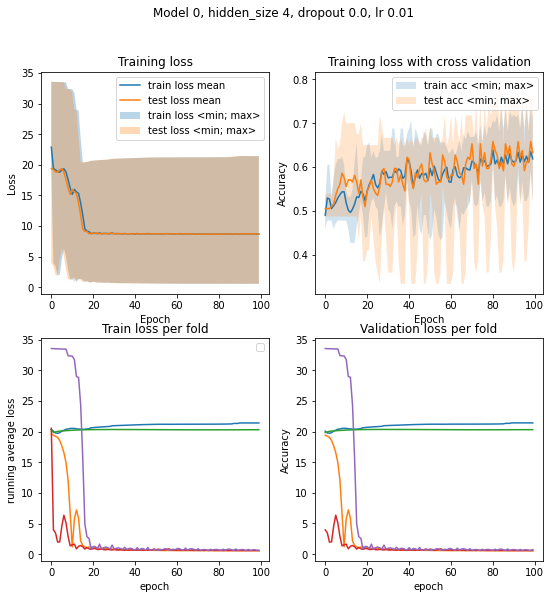

No handles with labels found to put in legend.


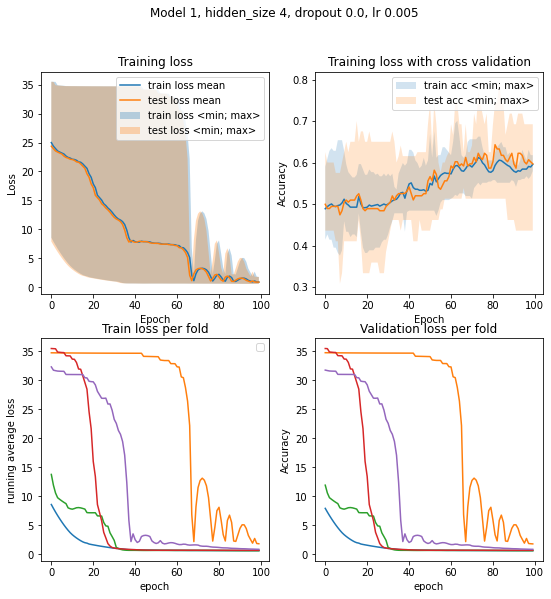

No handles with labels found to put in legend.


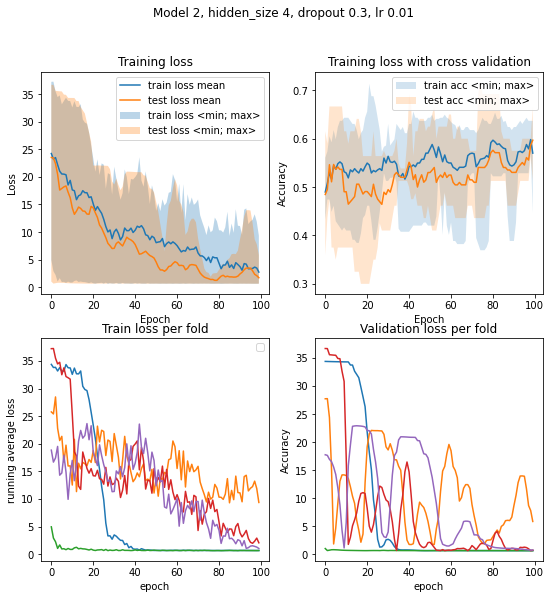

No handles with labels found to put in legend.


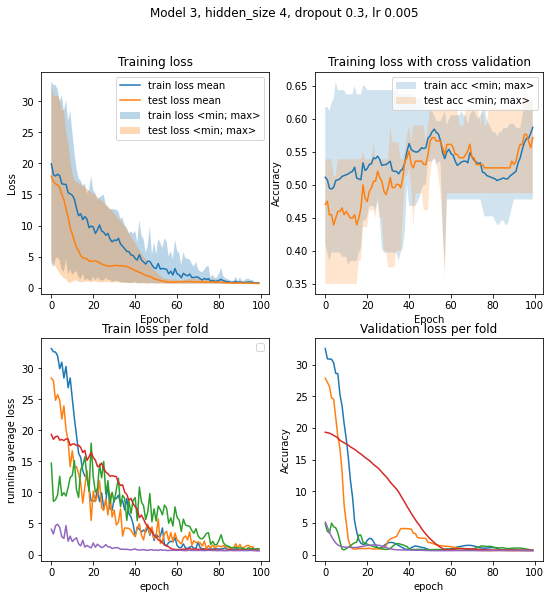

No handles with labels found to put in legend.


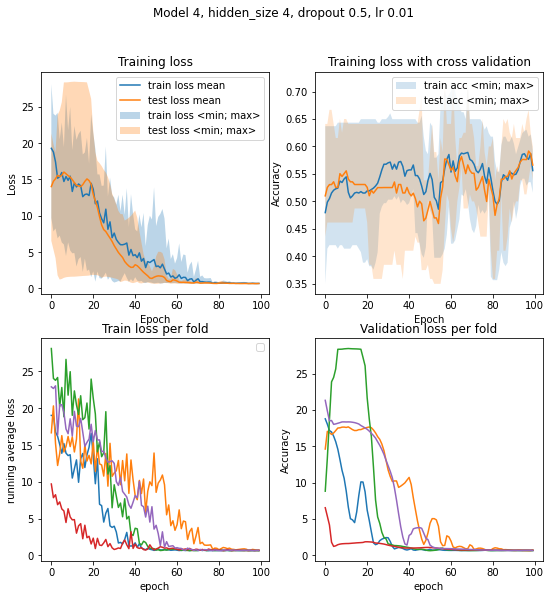

No handles with labels found to put in legend.


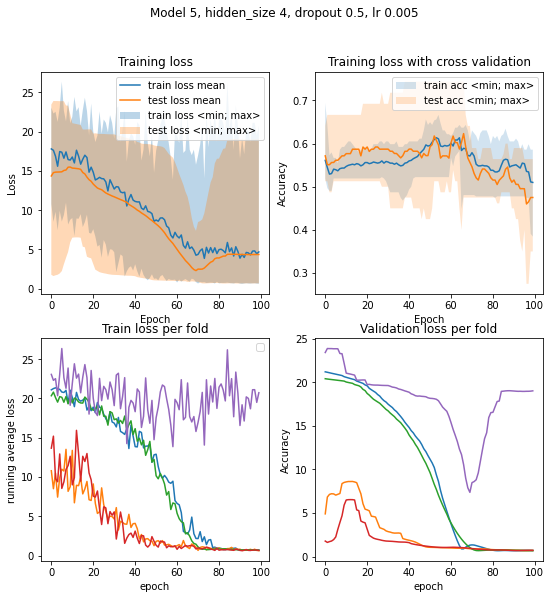

No handles with labels found to put in legend.


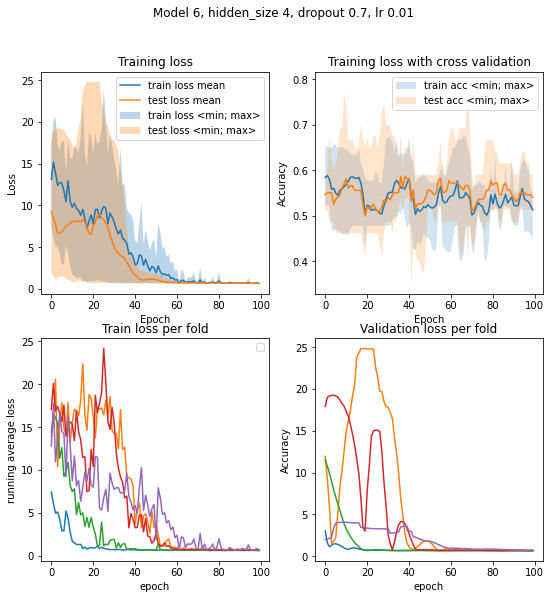

No handles with labels found to put in legend.


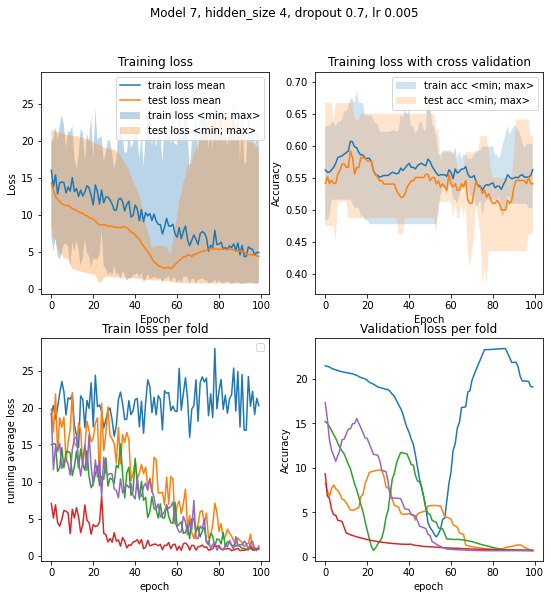

No handles with labels found to put in legend.


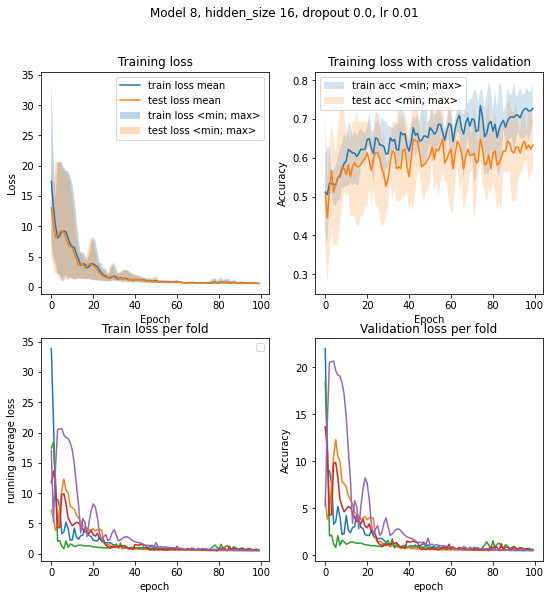

No handles with labels found to put in legend.


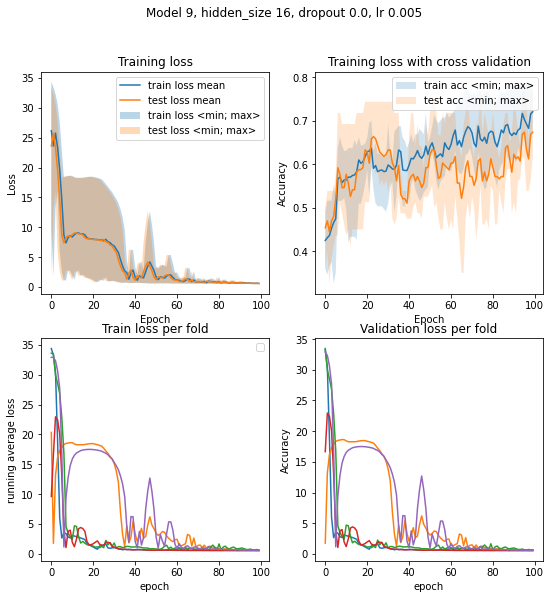

No handles with labels found to put in legend.


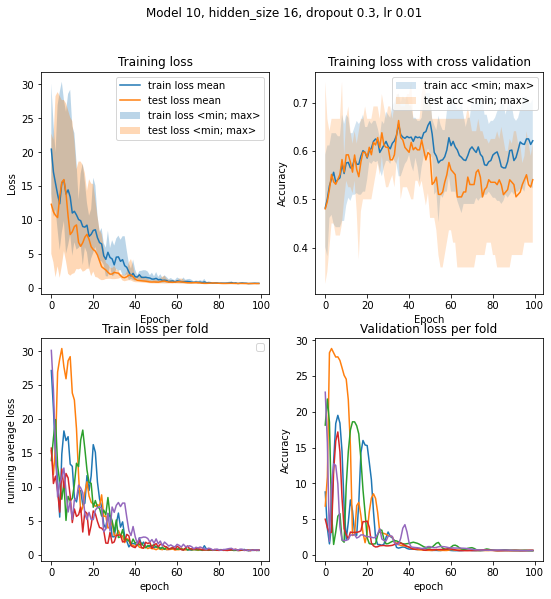

No handles with labels found to put in legend.


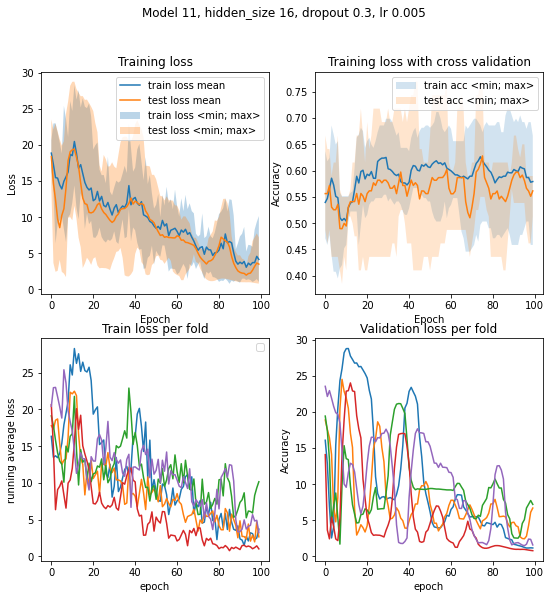

No handles with labels found to put in legend.


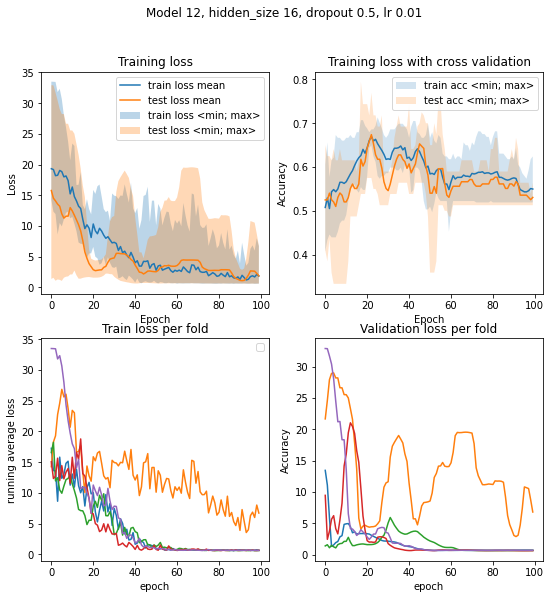

No handles with labels found to put in legend.


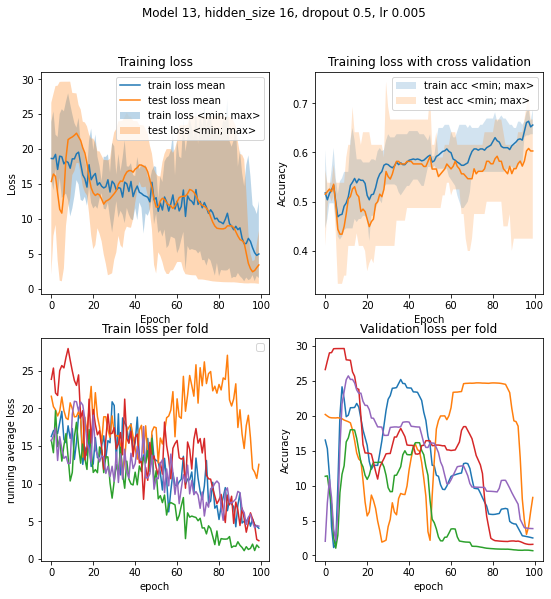

No handles with labels found to put in legend.


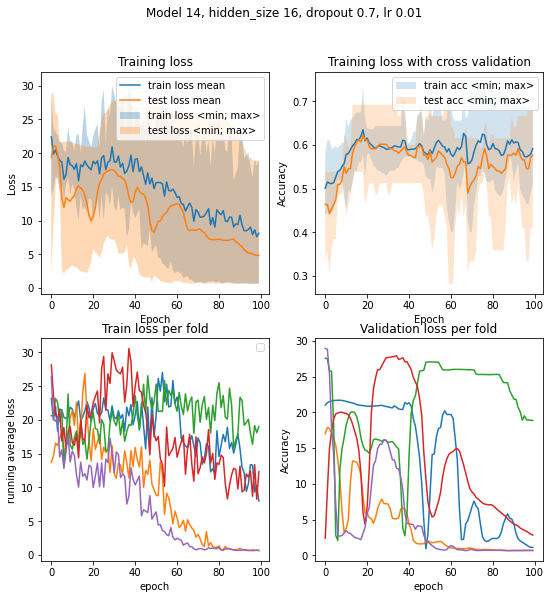

No handles with labels found to put in legend.


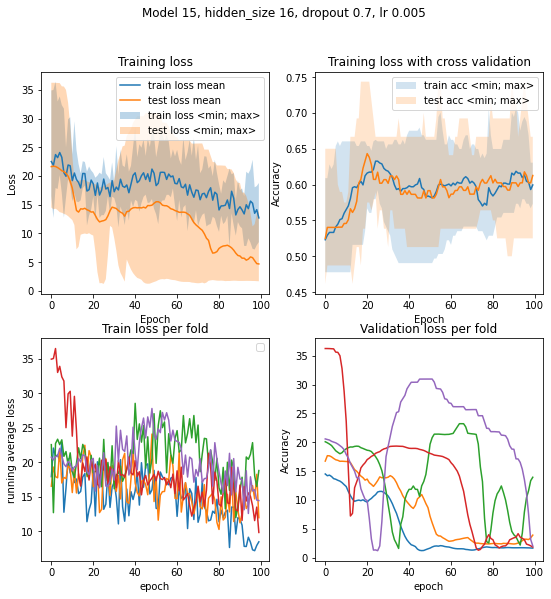

No handles with labels found to put in legend.


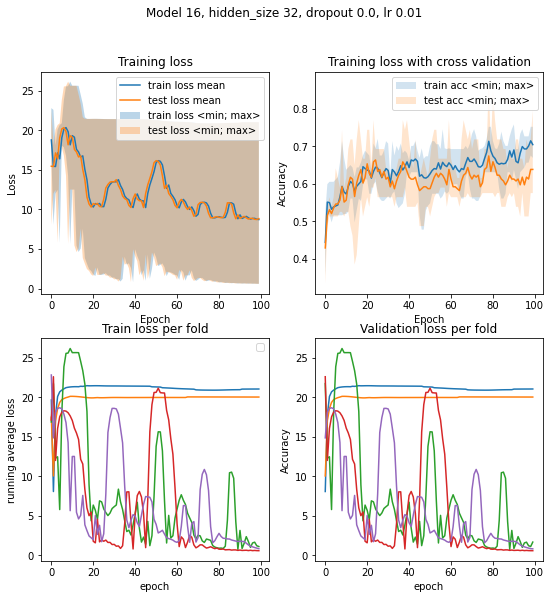

No handles with labels found to put in legend.


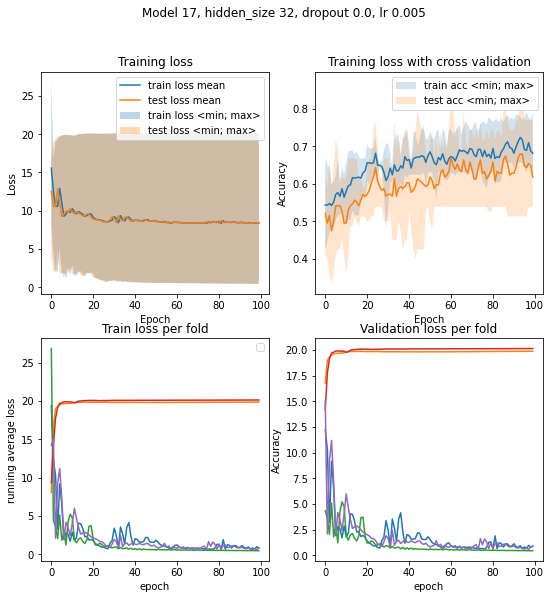

No handles with labels found to put in legend.


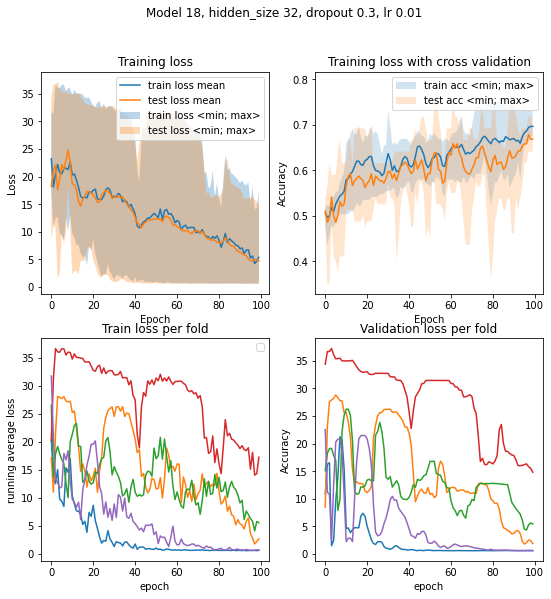

No handles with labels found to put in legend.


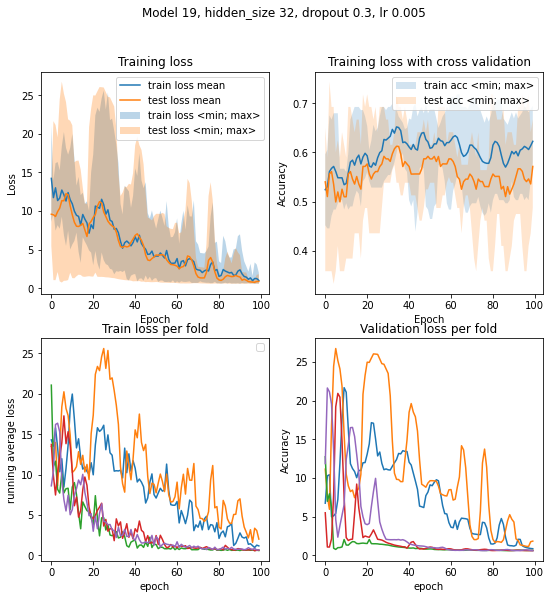

No handles with labels found to put in legend.


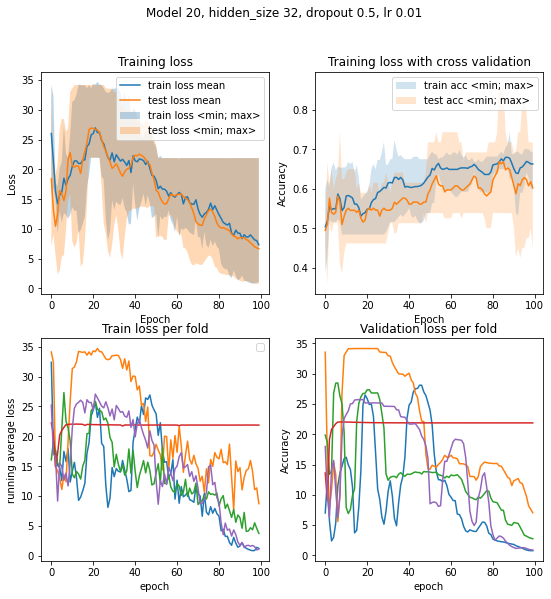

No handles with labels found to put in legend.


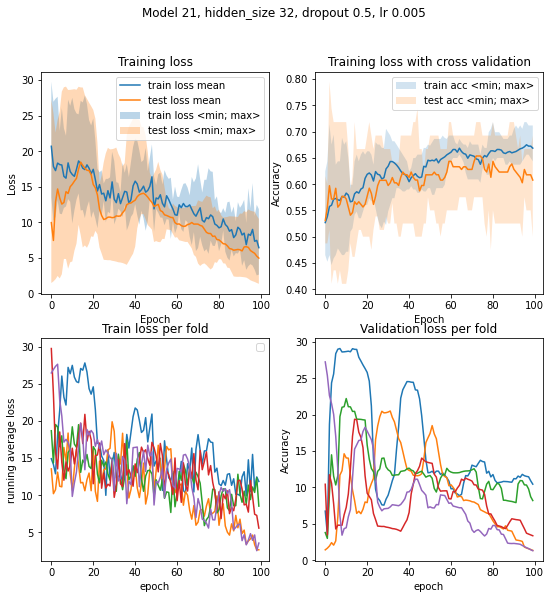

No handles with labels found to put in legend.


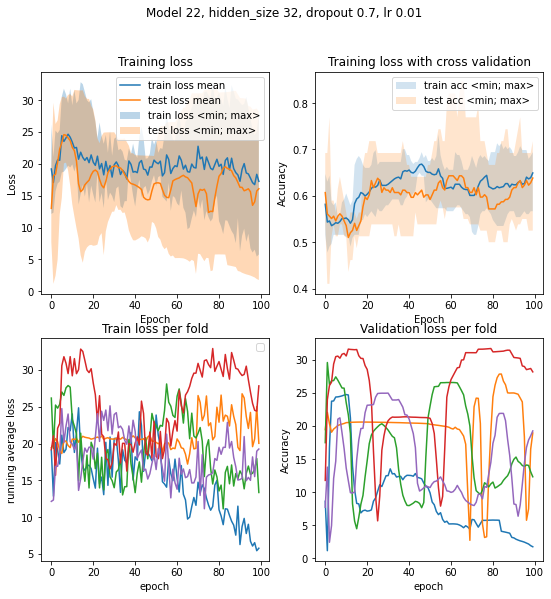

No handles with labels found to put in legend.


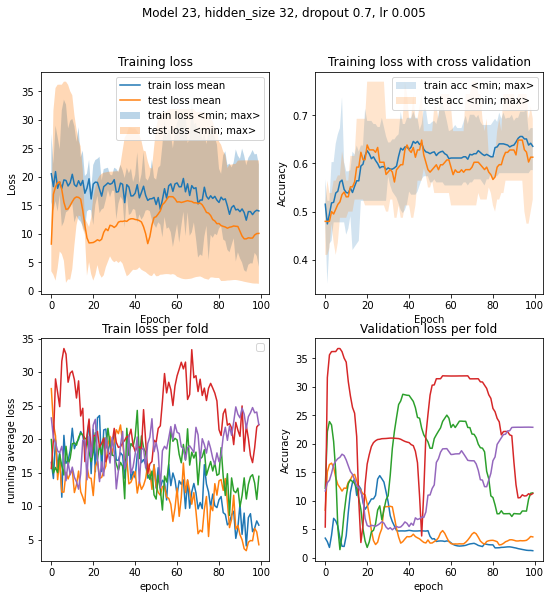

In [14]:
for i, foldperf in enumerate(results):
    train_loss = np.vstack([foldperf[fold]['train_loss'] for fold in foldperf])
    test_loss = np.vstack([foldperf[fold]['test_loss'] for fold in foldperf])
    train_acc = np.vstack([foldperf[fold]['train_acc'] for fold in foldperf])
    test_acc = np.vstack([foldperf[fold]['test_acc'] for fold in foldperf])
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 9))
    fig.suptitle(f'Model {i}, hidden_size {model_params[i][0]}, dropout {model_params[i][1]}, lr {model_params[i][2]}')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.title.set_text('Training loss')
    ax1.fill_between(range(num_epochs), train_loss.min(0), train_loss.max(0), alpha=0.3, label="train loss <min; max>")
    ax1.fill_between(range(num_epochs), test_loss.min(0), test_loss.max(0), alpha=0.3, label="test loss <min; max>")

    ax1.plot(range(num_epochs), train_loss.mean(0), label='train loss mean')
    ax1.plot(range(num_epochs), test_loss.mean(0), label='test loss mean')
    ax1.legend()
    
    
    
    ax2.title.set_text("Training loss with cross validation")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.fill_between(range(num_epochs), train_acc.min(0), train_acc.max(0), alpha=0.2, label="train acc <min; max>")
    ax2.fill_between(range(num_epochs), test_acc.min(0), test_acc.max(0), alpha=0.2, label="test acc <min; max>")

    ax2.plot(range(num_epochs), train_acc.mean(0))

    ax2.plot(range(num_epochs), test_acc.mean(0))
    ax2.legend()

    
    
    ax3.title.set_text('Train loss per fold')
    for l in train_loss:
        ax3.plot(l)
#     for l in train_loss:
#         ax3.plot(l, 'b-', alpha=0.5)
#     for l in test_loss:
#         ax3.plot(l, 'r-', alpha=0.5)
#     ax3.plot(np.convolve(train_loss.mean(0), np.ones(20)/20, mode='valid'), label='train loss')
#     ax3.plot(np.convolve(test_loss.mean(0), np.ones(20)/20, mode='valid'), label='test loss')
    ax3.set_xlabel('epoch')
    ax3.set_ylabel('running average loss')

    ax3.legend()
    
    ax4.title.set_text('Validation loss per fold')
    for l in test_loss:
        ax4.plot(l)
#     ax3.plot(np.convolve(train_loss.mean(0), np.ones(20)/20, mode='valid'), label='train loss')
#     ax3.plot(np.convolve(test_loss.mean(0), np.ones(20)/20, mode='valid'), label='test loss')
    ax4.set_xlabel('epoch')
    ax4.set_ylabel('Accuracy')
    plt.show()


In [15]:
accs = []
for i, foldperf in enumerate(results):
    accs.append(np.vstack([foldperf[fold]['test_acc'][-1] for fold in foldperf]).mean(0))
best_params = model_params[np.asarray(accs).argmax()]



In [17]:
hidden_size, dropout, lr = best_params
model = RGCN(in_feats, hidden_size, dropout, num_edge_types)

train_loader = GraphDataLoader(train_graphs, batch_size=1000)
# test_loader = GraphDataLoader(train_graphs, batch_size=1000)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}
train_loss = []
train_acc = []

for epoch in range(num_epochs):
    loss = train(model,train_loader,optimizer)
    acc = evaluate(model, train_loader)



    train_loss.append(loss)
    train_acc.append(acc)


C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


<Figure size 432x288 with 0 Axes>

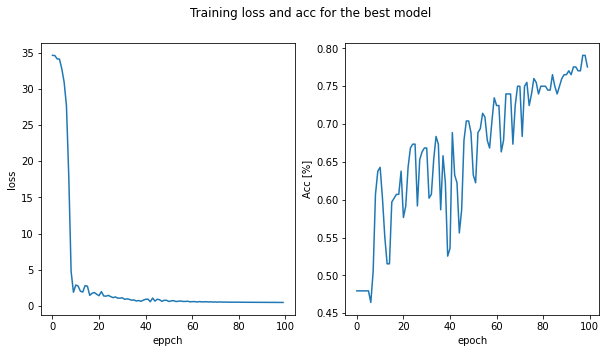

In [18]:
plt.figure()
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5))
plt.suptitle('Training loss and acc for the best model')
ax1.set_xlabel('eppch')
ax1.set_ylabel('loss')
ax1.plot(train_loss)

ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc [%]')
ax2.plot(train_acc)

plt.show()

In [19]:
###### test_loader = GraphDataLoader(test_graphs, batch_size=1000)

print('best params: hidden size {}, dropout {}, Adam learning rate{}'.format(*best_params))
acc = evaluate(model, test_loader)
print(f'Model test acc is {acc*100}%')

best params: hidden size 16, dropout 0.0, Adam learning rate0.005
Model test acc is 87.17948717948718%


In [20]:
model

RGCN(
  (in_layer): RelGraphConv(
    (linear_r): TypedLinear(in_size=5, out_size=16, num_types=1)
    (activation): ReLU()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (dropout1): Dropout(p=0.0, inplace=False)
  (out_layer): RelGraphConv(
    (linear_r): TypedLinear(in_size=16, out_size=16, num_types=1)
    (activation): ReLU()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (dropout2): Dropout(p=0.0, inplace=False)
  (global_mean_pool): AvgPooling()
  (fc): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)